## Example periodic star metric including crowding in the Monte Carlo trials ##

WIC 2015-01-03 - example metric where crowding uncertainty is incorporated within the Monte Carlo runs. 

In some (many?) cases where Monte Carlo is performed on a large number of fake lightcurves at a given slicePoint, with high-amplitude brightness changes (e.g. realizations of a dwarf nova outburst in crowded region; e.g. realizations of ellipsoidal variation in crowded region) it may be preferable to apply the crowding uncertainty separately to each each trial lightcurve within the Monte Carlo loop, since the crowding uncertainty is magnitude-dependent. 

It was not clear to me how to make this work with two separate metrics (e.g. how to combined the new CrowdingMetrics with the periodicStarMetric) so I refactored one of the crowding metrics (in this case Knut Olsen's tutorials/CrowdingMetric.ipynb) into a separate module that can be imported to the Metric itself. 

This Notebook gives an example. The crowding error is in module confusion.py with an example metric that uses it, in module sineMetricWithCrowd.py . Since I use knutago's version of crowding information, this also expects the list of luminosity functions and field information in the subdirectory "./lfs/" . (This can be tweaked as an argument to confusion.CrowdingSigma on initialization.) Downloading the directory containing this notebook and then unzipping the tarball should bring everything down that is specific to this Notebook (apart from the OpSim database file itself).

**OpSIM run chosen:** All the examples in this Notebook use the PanSTARRS-like OpSim run (ops2_1092) to isolate the effects of crowding on lightcurve recovery. The enigma_1189 still has observations in the Galactic Plane that are heavily front-loaded towards the beginning of the survey, which may lead to recovery drop-outs that are not due to crowding. 

In [1]:
%matplotlib inline

In [2]:
# Some standard items
import numpy as np
import time

In [3]:
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

/Users/clarkson/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
# the mag(5sig)-to-snr metric
from lsst.sims.maf.utils import m52snr

In [5]:
# Bring in the periodicStarMetric
import sineMetricWithCrowd as sM

In [6]:
# not needed for the metric, but needed for this notebook
import matplotlib.pyplot as plt
import confusion

## Illustration of crowding uncertainty vs magnitude ##

Here we take a single slice and generate a large-amplitude sinusoidal lightcurve to illustrate the impact of confusion uncertainty on the lightcurve. 

We then use the confusion.CrowdSigma object to estimate errors due to crowding, and apply them to each magnitude in the "trial" lightcurve. The end result of this subsection is a plot showing crowding and photometric errors along the lightcurve.

In [7]:
# Pick coordinates - we use a certain window towards the inner Milky Way...
raDegPlot = 270.75
deDegPlot = -30.01

# We want to pull down the OpSim exposure information for this location. 
# First set up, ensuring the seeing information is passed through...
raPlot = np.radians(raDegPlot)
decPlot = np.radians(deDegPlot)

lCols = ['filter','fiveSigmaDepth','expMJD', 'finSeeing']
metricPlot = metrics.PassMetric(cols=lCols)
slicerPlot = slicers.UserPointsSlicer(raPlot, decPlot, \
                                      lonCol='ditheredRA', latCol='ditheredDec')
sqlPlot = ''
outDirPlot = 'crowdPullLC_1092'

# we need to reconnect separately to pass thru to output directory and db
dbFilePlot='ops2_1092_sqlite.db'
opsimdbPlot = utils.connectOpsimDb(dbFilePlot)
resultsDbPlot = db.ResultsDb(outDir=outDirPlot)

bundlePlot = metricBundles.MetricBundle(metricPlot,slicerPlot,sqlPlot)
bgPlot =  metricBundles.MetricBundleGroup({0:bundlePlot}, opsimdbPlot,
                                      outDir=outDirPlot, resultsDb=resultsDbPlot)


In [8]:
# ... and run:
tStartPlot = time.time()
bgPlot.runAll()
tEndPlot = time.time()
print "Time elapsed passing data through: %.2f minutes" % ((tEndPlot - tStartPlot)/60.)

Querying database with no constraint.
Found 2469027 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Time elapsed passing data through: 1.90 minutes


In [9]:
# We want to simulate a large-amplitude variation. Pick parameters for large amplitude 
# variation visible by eye.
genPeriod = 900.
genPhase = 5.
genAmp = 3.
meanMag = 20.
magList = [meanMag for i in range(6)]

In [10]:
# Generate this variation. (Lines borrowed from peterY's periodicStarMetric)
inSlice = bundlePlot.metricValues.data[0]
mjdCol = 'expMJD'
filterCol = 'filter'

# perform the same data preparation as in the original metric
t = np.empty(inSlice.size, dtype=zip(['time','filter'],[float,'|S1']))
t['time'] = inSlice[mjdCol]-inSlice[mjdCol].min()
t['filter'] = inSlice[filterCol]

trueLC = sM.periodicStar(t, genPeriod, genPhase, genAmp, *magList)

In [11]:
# Now convert OpSim info into 1-sigma photometric uncertainty.
m5Col = 'fiveSigmaDepth'
snr = m52snr(trueLC,inSlice[m5Col])
sigmaPhot = 2.5*np.log10(1.+1./snr)

In [12]:
# Set up to estimate the crowding error at each point. For consistency, use the RA, DEC 
# that came down with the slice. I
raFirst = inSlice['ditheredRA'][0]
decFirst = inSlice['ditheredDec'][0]
PhotConfuse = confusion.CrowdingSigma(inSlice, magInput=trueLC, ra=raFirst, dec=decFirst)
PhotConfuse.getErrorFuncAndSeeing()

In [13]:
# for-loop for Monte Carlo at this slicePoint might be declared here.
# For now, let's just set a view of the "true" lightcurve
trialLC = trueLC

In [14]:
# Estimate the error due to crowding for this lightcurve. 
PhotConfuse.magSamples = np.copy(trialLC)
PhotConfuse.calcSigmaSeeingFromInterp()
sigmaCrowd = np.copy(PhotConfuse.sigmaWithSeeing)

In [15]:
# We now have the 1-sigma values for each point for photometric and 
# for crowding error. Turn them into perturbations for plotting later.
perturbPhot = np.random.randn(trialLC.size) * sigmaPhot
perturbCrowd = np.random.randn(trialLC.size) * sigmaCrowd

In [16]:
# at the moment we only have crowding information for r-band. Select that out now.
gR = np.where(t['filter'] == "r")

# Set a few views for convenience below
rSor = np.argsort(t[gR]['time'])
figTime = t[gR]['time'][rSor]
errPhot = perturbPhot[gR][rSor]
errCrowd = perturbCrowd[gR][rSor]
errBoth = np.sqrt(errPhot**2 + errCrowd**2)

figLCOrig = trialLC[gR][rSor]
figLCPhot = figLCOrig + errPhot
figLCBoth = figLCPhot + errCrowd

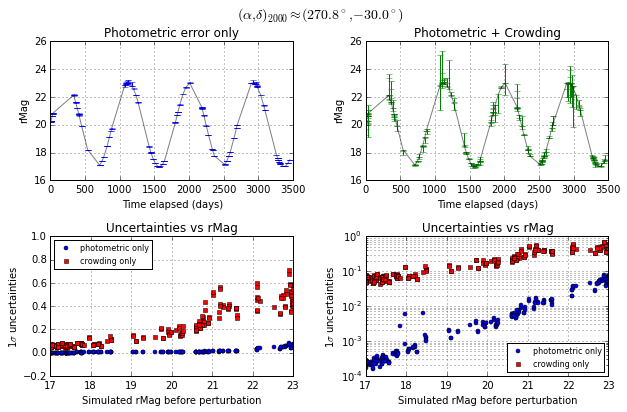

In [17]:
# Let's plot a couple of figures.
plt.figure(1, figsize=(10,6))
plt.clf()
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.suptitle(r'$(\alpha, \delta)_{2000} \approx (%.1f^\circ, %.1f^\circ)$' \
             % (raDegPlot, deDegPlot), fontsize=14)

plt.subplot(222)
plt.errorbar(figTime, figLCBoth, errBoth, ls='None', color='g')
plt.plot(figTime, figLCOrig, 'k-', alpha=0.5)
plt.xlabel('Time elapsed (days)')
plt.ylabel('rMag')
plt.title('Photometric + Crowding')
plt.grid(which='both')
yRange = np.copy(plt.ylim())

plt.subplot(221)
plt.errorbar(figTime, figLCPhot, errPhot, ls='None')
plt.plot(figTime, figLCOrig, 'k-', alpha=0.5)
plt.xlabel('Time elapsed (days)')
plt.ylabel('rMag')
plt.title('Photometric error only')
plt.grid(which='both')
plt.ylim(yRange)

plt.subplot(223)
plt.plot(figLCOrig, sigmaPhot[gR][rSor], 'bo', ms=4, label='photometric only')
plt.plot(figLCOrig, sigmaCrowd[gR][rSor], 'rs', ms=4, label='crowding only')
plt.grid(which='both')
plt.xlabel('Simulated rMag before any perturbation')
plt.ylabel(r'1$\sigma$ uncertainties')
plt.title('Uncertainties vs rMag')
plt.ylim(-0.2,1.0)
plt.legend(loc=2, fontsize=8, numpoints=1)

plt.subplot(224)
plt.semilogy(figLCOrig, sigmaPhot[gR][rSor], 'bo', ms=4, label='photometric only')
plt.semilogy(figLCOrig, sigmaCrowd[gR][rSor], 'rs', ms=4, label='crowding only')
plt.grid(which='both')
plt.xlabel('Simulated rMag before any perturbation')
plt.ylabel(r'1$\sigma$ uncertainties')
plt.title('Uncertainties vs rMag')
plt.legend(loc=4, fontsize=8, numpoints=1)
#plt.ylim(-0.2,1.0)

#plt.scatter(figTime, figLCBoth, edgecolor='0.5', s=9, c='b')

### Running period star metric at low-amplitude to explore crowding errors ###

Now we apply this to a metric in which Monte Carlo trials are performed inside the metric. This time we opt for a reasonably short-period, reasonably *low*-amplitude, sinusoidal variation at reasonably faint magnitudes to see a case where the recovery fraction depends strongly on location. 

In [47]:
# Now we create a new metric, this time with a number of monte carlo trials.
nSide=16 # reasonably fast on laptop 
meanMag = 22.
period=6.3 
nMonte=100 # small number to keep this reasonably quick on my laptop...
ampl=0.05  # low enough at this magn that crowding error should wash out entirely.
LMeans = [meanMag for i in range(6)]
metricMonte = sM.SineCrowdedMetric(nMonte=nMonte, period=period, periodTol=0.1, \
                                     amplitude=ampl, means=LMeans, \
                                   beVerbose=False)
slicerMonte = slicers.HealpixSlicer(nSide, lonCol='ditheredRA', latCol='ditheredDec')

# For the moment, don't include distance modulus.
# Let's make the distance modulus vary with healpix ID.
#distMod = np.arange(0.,slicerMonte.slicePoints['dec'].size)
distMod = np.repeat(0., slicerMonte.slicePoints['dec'].size)
slicerMonte.slicePoints['distMod'] = distMod

# Test sql query. We only have r-band crowding, so limit to this. 
# (SineCrowdedMetric also contains syntax to limit to r-band, so 
# it is safe to run this without the filter condition.)
sqlMonte='night < 14000 and filter = "r"'
#sqlMonte = 'night < 14000'

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [48]:
# Set up the database (this and the cell below are pasted from above
# to make re-running easier)
outDir='TESTperiodicWithCrowd_16'  # Results and images will go here..
dbFile='ops2_1092_sqlite.db'

In [49]:
# Connect to the database
opsimdb=utils.connectOpsimDb(dbFile)
resultsDb = db.ResultsDb(outDir=outDir)

In [50]:
bundleMonte = metricBundles.MetricBundle(metricMonte, slicerMonte, sqlMonte)
bgMonte = metricBundles.MetricBundleGroup({0:bundleMonte}, opsimdb,
                                      outDir=outDir, resultsDb=resultsDb)

In [51]:
# Run it
tStarted = time.time()
bgMonte.runAll()
print "INFO - Monte Carlo finished: %.2f minutes" % \
    ((time.time()-tStarted)/60.)

Querying database with constraint night < 14000 and filter = "r"
Found 544257 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
INFO - Monte Carlo finished: 16.58 minutes


/Users/clarkson/Progs/LSST_Stack_20151222/DarwinX86/sims_maf/sims_2.1.2/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:351: RuntimeWarning: invalid value encountered in equal
  b.metricValues.mask = np.where(b.metricValues.data==b.metric.badval,


Plotting figures with night < 14000 and filter = "r" sqlconstraint now.
monopole: 0.960878  dipole: lon: 77.6266, lat: 28.408, amp: 0.0597808
Plotting complete.


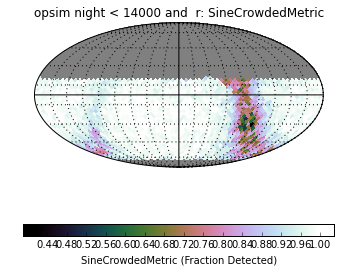

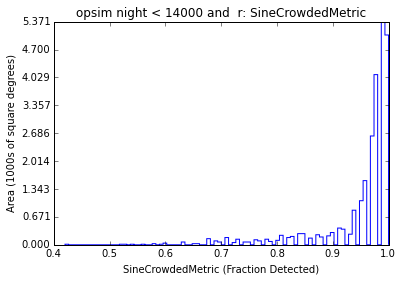

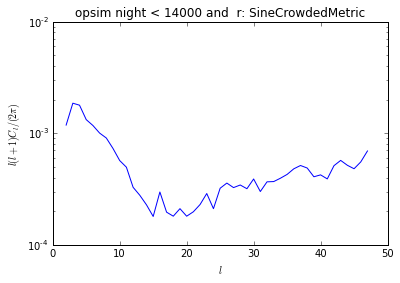

In [52]:
bgMonte.plotAll(closefigs=False)